# Chapter 6 - The ARMA Model


## Listing 6-1. Getting the Births data into Python


In [1]:
import pandas as pd

# Read the csv file
data = pd.read_csv("births_data.csv", sep=";")

# Keep useful columns
data = data[["Date", "Births"]]

## Listing 6-2. Aggregating the Births data to yearly data


In [2]:
data["year"] = data.Date.apply(lambda x: x[-4:])
data = data[["Births", "year"]].groupby("year").sum()
data.head()

,Births
year,
1749,80220
1750,78460
1751,27540
1752,27681
1753,11336


## Listing 6-3. Plotting the yearly Births data


<Axes: xlabel='year'>

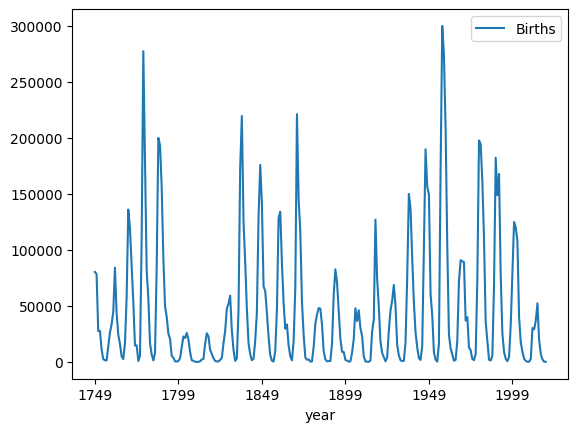

In [3]:
data.plot()

## Listing 6-4. Applying the ADF test to the Births yearly totals


In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["Births"])

pvalue = result[1]

print(f"Time-Series is: {'stationary' if pvalue < 0.05 else 'non-stationary'}")

Time-Series is: stationary


## Listing 6-7. Creating the ACF and PACF plots


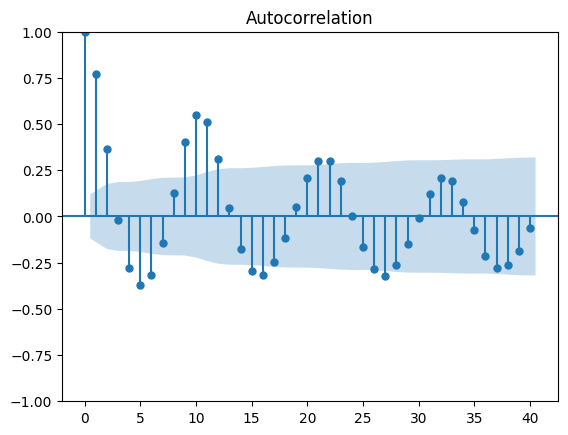

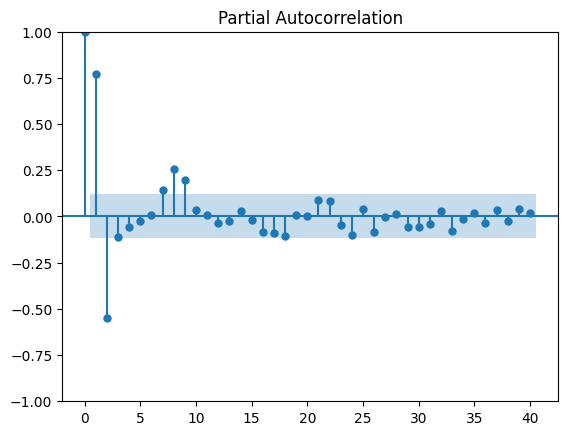

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(data["Births"], lags=40)
_ = plot_pacf(data["Births"], lags=40)

## Listing 6-8. Fitting the ARMA(1,1) model


0.6765045272313863


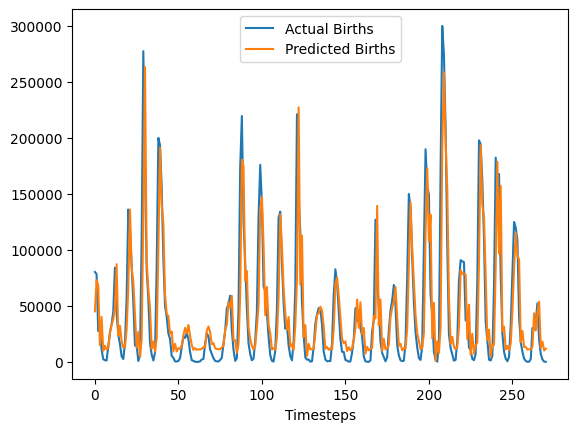

In [8]:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Forecast the first ARMA(1,1) model
mod = ARIMA(list(data["Births"]), order=(1, 0, 1))
res = mod.fit()
pred = res.predict()

# Print the r2 score of the prediction
print(r2_score(data, pred))

# Create the plot
plt.plot(list(data["Births"]))
plt.plot(pred)
plt.legend(["Actual Births", "Predicted Births"])
plt.xlabel("Timesteps")
plt.show()

## Listing 6-9. Plotting a histrogram of the residuals


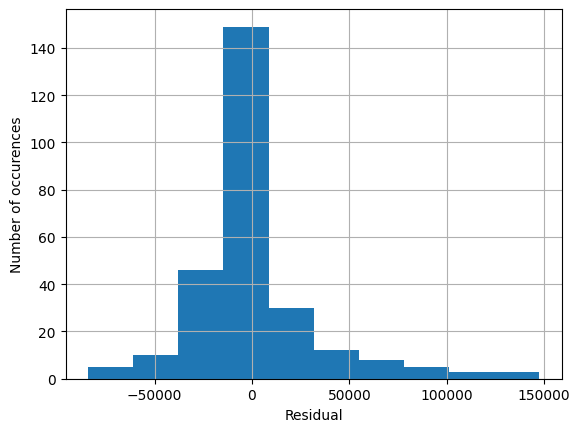

In [11]:
ax = pd.Series(res.resid).hist()
ax.set_ylabel("Number of occurences")
ax.set_xlabel("Residual")
plt.show()

## Listing 6-10. Obtaining the summary table of your model’s fit


In [13]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  271
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3204.666
Date:                Thu, 19 Feb 2026   AIC                           6417.332
Time:                        23:34:11   BIC                           6431.741
Sample:                             0   HQIC                          6423.117
                                - 271                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.508e+04   1.15e+04      3.922      0.000    2.26e+04    6.76e+04
ar.L1          0.6359      0.060     10.658      0.000       0.519       0.753
ma.L1          0.4774      0.066      7.185      0.000       0.347       0.608
sigma2      1.202e+09      1.215   9.89e+08      0.000     1.2e+09     1.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.43   Jarque-Bera (JB):               426.71
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             1.70
Prob(H) (two-sided):                  0.16   Kurtosis:                         8.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.95e+23. Standard errors may be unstable.
"""

## Listing 6-11. Grid search with cross-validation for optimal p and q


In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit


def train_model(p, q):
    errors = []
    tscv = TimeSeriesSplit(test_size=10)

    for train_index, test_index in tscv.split(data_array):
        X_train, X_test = data_array[train_index], data_array[test_index]
        X_test_orig = X_test

        fcst = []
        for step in range(10):
            mod = ARIMA(X_train, order=(p, 0, q))
            res = mod.fit()

            fcst.append(res.forecast(steps=1))

            X_train = np.concatenate((X_train, X_test[0:1, :]))
            X_test = X_test[1:]

        errors.append(r2_score(X_test_orig, fcst))

    pq_result = [p, q, np.mean(errors)]

    return pq_result


data_array = data.values

avg_errors = []

for p in range(13):
    for q in range(13):
        try:
            pq_result = train_model(p, q)
            print(pq_result)
            avg_errors.append(pq_result)
        except Exception:
            print(p, q, "failure")

avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ["p", "q", "error"]
result = avg_errors.pivot(index="p", columns="q")["error"]


In [ ]:
result

In [ ]:
# find max
maxi = 0
for p in range(12):
    for q in range(12):
        if result.iloc[p, q] > maxi:
            maxi = result.iloc[p, q]
            maxidx = (p, q)
print(maxi, maxidx)

## Listing 6-12. Showing the test prediction of the final model


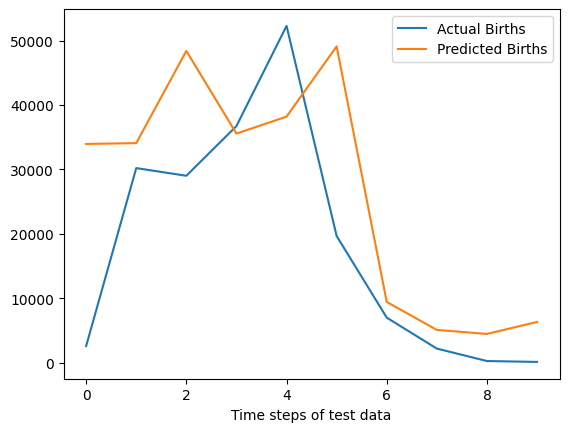

In [ ]:
data_array = data.values
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test

fcst = []
for step in range(10):
    mod = ARIMA(X_train, order=(2, 0, 9))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1, :]))
    X_test = X_test[1:]

plt.plot(X_test_orig)
plt.plot(fcst)
plt.legend(["Actual Births", "Predicted Births"])
plt.xlabel("Time steps of test data")
plt.show()

## Listing 6-13. Adding MLFlow


In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import mlflow

mlflow.autolog()

def train_model(p, q):

    errors = []
    tscv = TimeSeriesSplit(test_size=10)
    for train_index, test_index in tscv.split(data_array):
        X_train, X_test = data_array[train_index], data_array[test_index]
        X_test_orig = X_test
        fcst = []
        for step in range(10):
            mod = ARIMA(X_train, order=(p, 0, q))
            res = mod.fit()
            fcst.append(res.forecast(steps=1))
            X_train = np.concatenate((X_train, X_test[0:1, :]))
            X_test = X_test[1:]
        errors.append(r2_score(X_test_orig, fcst))
    pq_result = [p, q, np.mean(errors)]
    return pq_result


with mlflow.start_run():
    data_array = data.values
    avg_errors = []
    for p in [2]:
        for q in [9]:
            try:
                pq_result = train_model(p, q)

                # Log this metric to mlflow
                mlflow.log_metric("cross-validation-r2-score", pq_result[2])
                avg_errors.append(pq_result)
            except Exception:
                print(p, q, "failure")

    avg_errors = pd.DataFrame(avg_errors)
    avg_errors.columns = ["p", "q", "error"]
    result = avg_errors.pivot(index="p", columns="q")["error"]